# Room Acoustics
### Calculate and Graph: RT, FS, Early Reflections

-----------

#### Instructions:
* Drag in IR audio file (must be python compatible, .wav recommended) to the same folder as this .ipynb file
* In the last cell where it says FileName, type the name of the IR audio file in single quotes
* Finally, run all cells below in order

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio
from scipy import interpolate as itp
from scipy import signal as sig

In [2]:
#Anonamous author on CodeGrepper.com

#Finds index of the value in an input array nearest to a specified value
#Returns the value of the array at that index

def find_nearest(array, value):
    
    # If input is a list or tuple, turn it into an array
    array = np.asarray(array)
    
    # Subtract the value from every array element and then find the index of the minimum array element
    idx = (np.abs(array - value)).argmin()
    
    # Return the closest array element to the input value
    return array[idx]

In [3]:
# Anonymous author on StackOverflow.com

# This smooth function smooths an input signal, with parameter box_pts causing more smoothing the higher the value
# Return the smoothed signal

def smooth(y, box_pts):
    
    # Smooth using a moving average with convolution
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    
    return y_smooth

In [4]:
def sample(signal,freq,fs):
    sample = int(freq*len(signal)/fs)
    return sample

In [5]:
def plot_fft(x,st=0,en=44100,together='false'):
    frequency = np.arange(len(x)) * sr/len(x)
    if (together == 'false'):
        plt.figure(figsize = (12,7))
    plt.plot(frequency,x)
    plt.xlim([st,en])
    plt.grid()
    plt.xlabel('Frequency (Hz)')
    plt.title('FFT ')
    return

In [6]:
def Calculate_RT(signal, plot_sig=False, plot_ER=False, plot_FS=False, plot_RT=False):
    
    #Initialize signal
    name = signal[0:len(signal)-4]
    x,sr = sf.read(signal)
    try:
        x = x[:,0]
    except:
        pass
    fft = np.fft.fft(x)
    filtered = (np.fft.ifft(fft))
    filtered_nonzero = filtered
    zeros = np.where(np.abs(np.real(filtered))<(10**-10))
    for i in range(len(zeros)-2):
        filtered_nonzero[zeros[i]] = filtered[zeros[i]-2]*filtered[zeros[i]+2]
    filtered_nonzero = np.where(filtered_nonzero==0,10*10**-10,filtered_nonzero)
    IR = 20 * np.log10((filtered_nonzero)/np.max(np.abs(x)))
    t_v = np.arange(0,len(IR)/sr,1/sr)
    f_v = np.arange(len(x)) * sr/len(x)
    smoothed = np.real(smooth(IR,5001))
    
    if (len(t_v)!=len(IR)):
        t_v = t_v[0:len(IR)]

        
    if (plot_sig==True):
    
        #Plot Smoothed Signal
        plt.figure(figsize=(7,4))
        plt.plot(t_v,np.real(IR),'c',zorder = 1,label='Original')
        plt.plot(t_v,smoothed,'m',zorder=2,label='Smoothed')
        plt.ylim([np.min(smoothed),0])
        plt.title('IR (smoothed): ' + name)
        plt.xlabel('Time (sec)')
        plt.ylabel('Amplitude (dB)')
        plt.grid()
        plt.legend()
    
    #Calculate horizontal lines
    y_down = np.linspace(0,len(IR)/sr,100)
    level0 = smoothed[0]
    down5 = np.linspace(level0-5,level0-5,100)
    down10 = np.linspace(level0-15,level0-15,100)
    down20 = np.linspace(level0-25,level0-25,100)
    down30 = np.linspace(level0-35,level0-35,100)
    down60 = np.linspace(level0-65,level0-65,100)
    
    #Calculate time of intersections
    #Idx of intersections is first occurance in the signal of xdB down, divided by sample rate gives time
    t_5 = (np.where(np.around(smoothed,decimals=1)==np.around(level0-5,decimals=1))[0][0])/sr
    t_10 = (np.where(np.around(smoothed,decimals=1)==np.around(level0-15,decimals=1))[0][0])/sr
    t_20 = (np.where(np.around(smoothed,decimals=1)==np.around(level0-25,decimals=1))[0][0])/sr
    t_30 = (np.where(np.around(smoothed,decimals=1)==np.around(level0-35,decimals=1))[0][0])/sr
    try:
        t_60 = (np.where(np.around(smoothed[0:len(smoothed)//2],decimals=0)==np.around(level0-65,decimals=0))[0][0])/sr
    except:
        t_60 = t_30 * 2
        

# FREQUENCY RESPONSE
        
    if (plot_FS==True):
        
        #Plot Frequency Response Entire Signal
        plt.figure(figsize=(7,4))
        plt.plot(f_v,np.abs(fft))
        plt.xlim([0,sr/2])
        plt.title('FS ' + name)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('IL (dB)')
        plt.grid()

        #Plot Frequency Response Direct
        plt.figure(figsize=(7,4))
        fft_direct = (np.abs(np.fft.fft(x[int((.002)*sr):int((.01)*sr)])))
        f_v_direct = np.arange(len(fft_direct)) * sr/len(fft_direct)
        plt.plot(f_v_direct,np.abs(fft_direct))
        plt.xlim([0,sr/2])
        plt.title('FS Direct ' + name)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('IL (dB)')
        plt.grid()

        #Plot Frequency Response T30
        plt.figure(figsize=(7,4))
        fft_t30 = np.real(np.fft.fft(x[int((t_30)*sr):int((t_30)*sr)+len(x[int((.002)*sr):int((.01)*sr)])]))
        f_v_t30 = np.arange(len(fft_t30)) * sr/len(fft_t30)
        plt.plot(f_v_t30,np.abs(fft_t30))
        plt.xlim([0,sr/2])
        plt.title('FS T30 ' + name)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('IL (dB)')
        plt.grid()
    
    
# EARLY REFLECTIONS 

    #Calculate Early Reflections (using this one now)
    print(name[0:len(name)-4], '\n')
    print('Number of Early Reflections, Ave time between ERs: (ms)')
    ER_data = np.zeros([4,2])
    for i in range(1,5):
        ER_signal = np.abs(x[0:int(sr*(i/100))])
        ER_idx = sig.find_peaks(ER_signal, distance = 100)[0]
        ER_t = ER_idx/sr
        num_ER = np.size(ER_t)
        diff_array = np.ediff1d(ER_t)
        diff_ave = np.average(diff_array)*1000
        ER_data[i-1,0] = num_ER
        ER_data[i-1,1] = diff_ave
                
    print('{', ER_data[0,0], ',', ER_data[0,1], ';')
    print(ER_data[1,0], ',', ER_data[1,1], ';')
    print(ER_data[2,0], ',', ER_data[2,1], ';')
    print(ER_data[3,0], ',', ER_data[3,1], '}')

    if (plot_ER==True):

        #Plot Early Reflections
        plt.figure(figsize=(7,4))
        plt.plot(t_v,np.abs(x),'c',zorder = 1,label='Original')
    #     plt.plot(t_v,smooth(np.abs(x),10),'m',zorder = 2,label='Smoothed')
        plt.title('Early Reflections: ' + name)
        plt.xlabel('Time (sec)')
        plt.ylabel('Amplitude (dB)')
        plt.xlim([0,.02])
        plt.grid()

    
# REVERB TIME
    
    if (plot_RT==True):
    
        #Plot RT60
        plt.figure(figsize=(7,4))
        plt.plot(t_v,smoothed,'c',zorder=2,label='Signal (Smoothed)',linewidth=4)
        plt.title('RT60: ' + name)
        plt.xlabel('Time (sec)')
        plt.ylabel('Amplitude (dB)')

        #Horizontal dotted lines
        plt.plot(y_down,down5,'k--')
        plt.plot(y_down,down10,'k--')
        plt.plot(y_down,down20,'k--')
        plt.plot(y_down,down30,'k--')
        plt.plot(y_down,down60,'k--')
        plt.xlim([0,t_60*1.1])
        plt.ylim([-100,0])

        #Plot dots for time of intersections 
        plt.plot(t_5,level0-5,marker = 'o',color='k',markersize=8)
        plt.plot(t_10,level0-15,marker = 'o',color='m',markersize=8)
        plt.plot(t_20,level0-25,marker = 'o',color='b',markersize=8)
        plt.plot(t_30,level0-35,marker = 'o',color='y',markersize=8)
        plt.plot(t_60,level0-65,marker = 'o',color='r',markersize=8)

        #Plot linear interpolations
        T10 = np.linspace(level0-5,level0-15,100)
        x_10 = np.linspace(t_5,t_10,100)
        plt.plot(x_10,T10,'m',label='T10')
        T20 = np.linspace(level0-5,level0-25,100)
        x_20 = np.linspace(t_5,t_20,100)
        plt.plot(x_20,T20,'b',label='T20')
        T30 = np.linspace(level0-5,level0-35,100)
        x_30 = np.linspace(t_5,t_30,100)
        plt.plot(x_30,T30,'y',label='T30')
        T60 = np.linspace(level0-5,level0-65,100)
        x_60 = np.linspace(t_5,t_60,100)
        plt.plot(x_60,T60,'r',label='T60')

        plt.legend()
        plt.grid()

    #Print calculation results
    print('\n' + 'Reverb Times:')
    print(np.around(t_10-t_5,decimals=2), '* 6 = RT10:', np.around(np.around((t_10-t_5),decimals=2)*6,decimals=2), 'sec')
    print(np.around(t_20-t_5,decimals=2), '* 3 = RT20:', np.around(np.around((t_20-t_5),decimals=2)*3,decimals=2), 'sec')
    print(np.around(t_30-t_5,decimals=2), '* 2 = RT30:', np.around(np.around((t_30-t_5),decimals=2)*2,decimals=2), 'sec')
    print('Observed RT60:', np.around(t_60-t_5,decimals=2), 'sec')
#     # For copying as array into Google Sheets
#     print('{', np.around(t_10-t_5,decimals=2), ',', np.around(np.around((t_10-t_5),decimals=2)*6,decimals=2), ';')
#     print(np.around(t_20-t_5,decimals=2), ',', np.around(np.around((t_20-t_5),decimals=2)*3,decimals=2), ';')
#     print(np.around(t_30-t_5,decimals=2), ',', np.around(np.around((t_30-t_5),decimals=2)*2,decimals=2), ';')
#     print(np.around(t_60-t_5,decimals=2), ',', np.around(t_60-t_5,decimals=2), '}')
    print()

(Grand) Ballroom 

Number of Early Reflections, Ave time between ERs: (ms)
{ 4.0 , 3.038548752834467 ;
7.0 , 3.0687830687830693 ;
11.0 , 2.8276643990929706 ;
14.0 , 2.8641200069771497 }

Reverb Times:
0.04 * 6 = RT10: 0.24 sec
0.16 * 3 = RT20: 0.48 sec
0.33 * 2 = RT30: 0.66 sec
Observed RT60: 1.11 sec



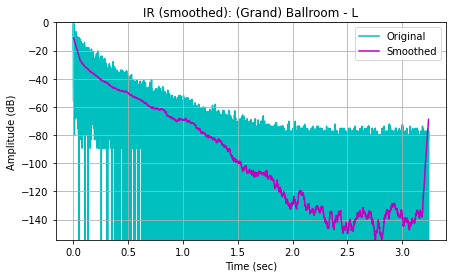

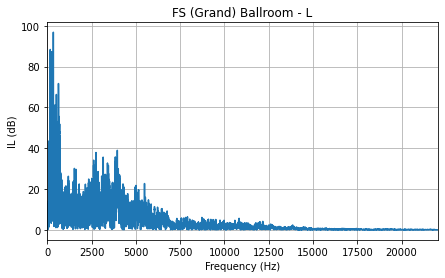

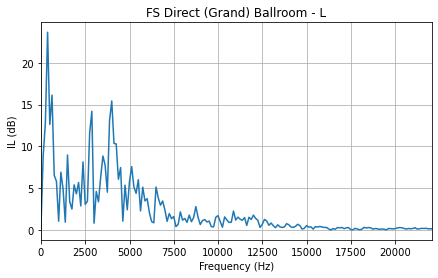

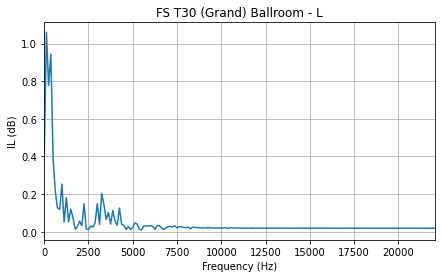

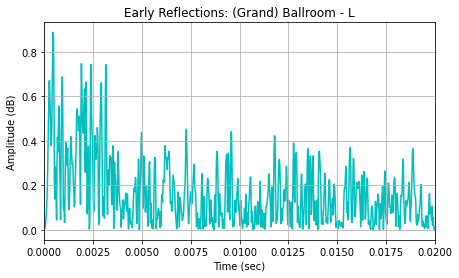

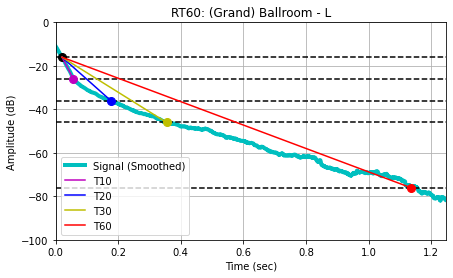

In [10]:
# Type the name of the IR audio file in single quotes below
    # (Must be python soundfile compatible filetype, .wav recommended)
    
FileName = '(Grand) Ballroom - L.wav'


# To plot any of the following graphs, change to True

#Smoothed signal
plot_sig = True
#Reverberation Time
plot_RT = True
#Early Reflections
plot_ER = True
#Frequency Response
plot_FS = True


# DO NOT CHANGE THE BELOW CODE
Calculate_RT(FileName, plot_sig, plot_ER, plot_FS, plot_RT)